# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.dummy import DummyClassifier 

## Откройте и изучите файл

Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Посмотрим на данные:

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет, посмотрим на корреляции признаков в данных

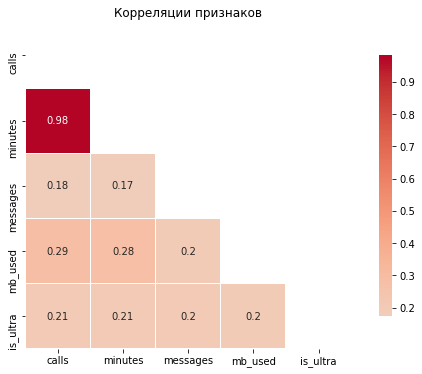

In [5]:
corr = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))


fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, center=0, cmap="coolwarm", square=True,
linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, mask=mask)
ax.set_title("Корреляции признаков")
plt.show()

У признаков `call` и `minutes` высокая степень корреляции.
Если эти признаки зависимы, это может ухудшить качество модели.

С другой стороны из корреляции не следует зависимость. Поробуем при обучении модели обучить ее на полных данных,
на данных без столбца `call` и на данных без столбца `minutes` и сравнить результаты.

Проверим датасет на сбалансированность

In [6]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Если все время рекомендовать тариф Smart - мы будем правы в 69% случаев. 

Действительно, это сразу решает бонусное задание)

## Разбейте данные на выборки

Спрятанной тестовой выборки у нас нет. Разобьем данные на обучающую и валидационные выборки в соотношении 4:1.

Специально выделять тестовую я не буду, за меня это сделают методы `RandomizedSearchCV` и `cross_val_score`

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345, shuffle=True, stratify=target)

Проверим корректость разбиения

In [8]:
print(features.shape[0], features_train.shape[0]+features_valid.shape[0])
print(target.shape[0], features_train.shape[0]+target_valid.shape[0])

print(features.shape[1], features_train.shape[1], features_valid.shape[1])

3214 3214
3214 3214
4 4 4


Все коректно, ничего не "зажевало")

Для проверки того, что корреляция `call` и `minutes` не ухудшает качество модели я добавлю наборы данных без них

In [9]:
features_train_without_calls = features_train.drop('calls', axis=1)
features_valid_without_calls = features_valid.drop('calls', axis=1)

features_train_without_minutes = features_train.drop('minutes', axis=1)
features_valid_without_minutes = features_valid.drop('minutes', axis=1)

In [10]:
train_data = {
    'data': features_train,
    'data_without_calls': features_train_without_calls,
    'data_without_minutes': features_train_without_minutes,
}

valid_data = {
    'data': features_valid,
    'data_without_calls': features_valid_without_calls,
    'data_without_minutes': features_valid_without_minutes,
}


## Исследуйте модели

Для исследования выберем классификаторы `RandomForestClassifier`, `LogisticRegression`, `DecisionTreeClassifier`

### RandomForestClassifier

Чтобы на перебирать все важные параметры модели в цикле, в поисках лучших сочетаний, будем исользовать `RandomizedSearchCV` - этот метод подбирает оптимальные с точки зрения качества модели гиперпараметры, и проводит кросс-валидацию результатов. 

В качестве основных параметров для RandomForestClassifier возьмем:
    
- n_estimators — число «деревьев» в «случайном лесу».
- max_features — число признаков для выбора расщепления.
- max_depth — максимальная глубина деревьев.
- min_samples_leaf — минимальное число объектов в листьях.
- bootstrap — использование 

In [11]:
def findRandomForestClassifierParams(features, target):
    """
    Функция выбирает наилучщий набор гиперпараметров для случайного леса для заданного датасета.
    Подбор гиперпараметров осуществляется с помошью RandomizedSearchCV.

    :param features: набор признаков
    :param target: целевая переменная
    :return: наилучший набор гиперпараметров модели
    """

    model = RandomForestClassifier(random_state=12345)

    n_estimators = [int(x) for x in np.linspace(start = 1, stop = 300, num = 20)]
    max_features = ['log2', 'sqrt', None]
    max_depth = [int(x) for x in np.linspace(start = 1, stop = 100, num = 25)]
    # min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 20)]
    min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 20)]
    bootstrap = [True, False]

    param_dist = {'n_estimators': n_estimators, # The number of trees in the forest.
                   'max_features': max_features,  #The number of features to consider when looking for the best split:
                   'max_depth': max_depth, # The maximum depth of the tree.
                   #'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}


    rs = RandomizedSearchCV(model,
                            param_dist,
                            n_iter = 100,
                            cv = 4,
                            # verbose = 1,
                            n_jobs=-1,
                            random_state=12345)
    rs.fit(features, target)
    return rs.best_params_


def getRandomForestClassifierScore(params, features, target):
    """
    Возвращает величину accuracy и обученную модель RandomForestClassifier
    при заданных гиперпараметрах

    :param params: гиперпараметры
    :param features: набор признаков
    :param target: целевая переменная
    :return: accuracy
    """
    model = RandomForestClassifier(random_state=12345, **params)
    model.fit(features, target)
    score = model.score(features, target)
    return score, model

Рассмотрим три варианта данных - целые, и с убранными столбцами

In [12]:
%%time

random_forest_result = dict()
for name, data in train_data.items():
    best_params = findRandomForestClassifierParams(data, target_train)
    score, model = getRandomForestClassifierScore(best_params, data, target_train)
    
    random_forest_result[name] = (model, score)
    
    print(name, score)
    print(best_params, '\n')     

data 0.8712563204978607
{'n_estimators': 189, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True} 

data_without_calls 0.8428626993387787
{'n_estimators': 268, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'max_depth': 29, 'bootstrap': False} 

data_without_minutes 0.8661999222092571
{'n_estimators': 300, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 9, 'bootstrap': True} 

CPU times: user 9min 45s, sys: 2.39 s, total: 9min 48s
Wall time: 9min 49s


Вывод: наличие и отсутствие столбцов `call` и `minutes`  кардинально на качество модели не влияет. Вместе с тем, оптимальные наборы гиперпараметров получились весьма различными

### DecisionTreeClassifier

В качестве основных параметров для DecisionTreeClassifier возьмем:
    
- max_features — число признаков для выбора расщепления.
- max_depth — максимальная глубина дерева.
- min_samples_leaf — минимальное число объектов в листьях.

In [13]:
def findDecisionTreeClassifierParams(features, target):
    """
    Функция выбирает наилучщий набор гиперпараметров для решающего дерева для заданного датасета.
    Подбор гиперпараметров осуществляется с помошью RandomizedSearchCV.

    :param features: набор признаков
    :param target: целевая переменная
    :return: наилучший набор гиперпараметров модели
    """

    model = DecisionTreeClassifier(random_state=12345)

    max_depth = [int(x) for x in np.linspace(start = 2, stop = 100, num = 25)]
    #min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 20)]
    min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 300, num = 20)]
    max_features = ["auto", "sqrt", "log2", None]

    param_dist = {#'criterion': criterion, 
                  # 'splitter': splitter,  
                   'max_depth': max_depth, 
                   #'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'max_features': max_features
                 }


    rs = RandomizedSearchCV(model,
                            param_dist,
                            n_iter = 100,
                            cv = 4,
                            # verbose = 1,
                            n_jobs=-1,
                            random_state=12345)
    rs.fit(features, target)
    return rs.best_params_


def getDecisionTreeClassifierScore(params, features, target):
    """
    Возвращает величину accuracy и обученную модель DecisionTreeClassifier
    при заданных гиперпараметрах

    :param params: гиперпараметры
    :param features: набор признаков
    :param target: целевая переменная
    :return: accuracy
    """

    model = DecisionTreeClassifier(random_state=12345, **params)
    model.fit(features, target)
    score = model.score(features, target)
    return score, model

In [14]:
%%time

decision_tree_result = dict()
for name, data in train_data.items():
    best_params = findDecisionTreeClassifierParams(data, target_train)
    score, model = getDecisionTreeClassifierScore(best_params, data, target_train)
    
    decision_tree_result[name] = (model, score)
    
    print(name, score)
    print(best_params, '\n') 

data 0.8059120964605212
{'min_samples_leaf': 17, 'max_features': 'sqrt', 'max_depth': 6} 

data_without_calls 0.8210812913263321
{'min_samples_leaf': 17, 'max_features': 'auto', 'max_depth': 91} 

data_without_minutes 0.8082458187475691
{'min_samples_leaf': 49, 'max_features': None, 'max_depth': 63} 

CPU times: user 6.57 s, sys: 16 ms, total: 6.59 s
Wall time: 6.6 s


Вывод: Результат похож на результат с использованием случайного леса -- наличие и отсутствие столбцов `call` и `minutes`  кардинально на качество модели не влияет. Оптимальные наборы гиперпараметров опять получились весьма различными

### LogisticRegression

У логистической регрессии такого обилия  гиперпараметров нет, используем cross_val_score для кросс-валидации

In [15]:
logistic_regression_result = dict()
for name, data in train_data.items():
    model = LogisticRegression(random_state=12345)
    score = cross_val_score(model, data, target_train, cv=4, scoring = 'accuracy').mean()
    model.fit(data, target_train)
    
    logistic_regression_result[name] = (model, score)
    
    print(name, score, '\n') 

data 0.7339458486553005 

data_without_calls 0.7374596057227851 

data_without_minutes 0.7355143820584003 



Выыод: у логистической регрессии результат хуже чем у случайного леса,  наличие и отсутствие столбцов call и `minutes` опять же кардинально на качество модели не влияет. 

### Вывод

Посмотрим на сводную таблицу

In [16]:
test_data_result = pd.DataFrame([
    {k:v[1] for k,v in random_forest_result.items()}, 
    {k:v[1] for k,v in decision_tree_result.items()},
    {k:v[1] for k,v in logistic_regression_result.items()}, 
    ],
    index = ['random_forest','decision_tree', 'logistic_regression', ])

test_data_result

,data,data_without_calls,data_without_minutes
random_forest,0.871256,0.842863,0.866200
decision_tree,0.805912,0.821081,0.808246
logistic_regression,0.733946,0.737460,0.735514


Наилучший результат на тестовых данных у случайного леса с полной информацией и о звонках и о их продолжительности. Удаление одного из признаков `call` и `minutes` существенно не влияет на качество модели - и даже незначительно ухущает. Можно сделать вывод что эти признаки независимы.

In [17]:
best_model = random_forest_result['data'][0]
best_model

RandomForestClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=189, random_state=12345)

## Исследование влияния количества деревьев на качество моделей

In [18]:
def getModelsForMaxDepthInvestigation(classifier,  X, y, max_depth):
    
    """
    Возвращает список обученных на признаках `X` и таргете `y` моделей
    с глубиной дерева от 1 до max_depth

    :param classifier: классификатор - DecisionTreeClassifier или RandomForestClassifier
    :param X: набор признаков
    :param y: целевая переменная
    :return: список обученных моделей
    """

    result = []
    for depth in range(1, max_depth):
        model = classifier(random_state=12345, max_depth=depth)
        model.fit(X, y)
        result.append(model)
    return result

In [19]:
%%time

DT_models = getModelsForMaxDepthInvestigation(DecisionTreeClassifier, features_train, target_train, 50)
RF_models = getModelsForMaxDepthInvestigation(RandomForestClassifier, features_train, target_train, 50)

DT_train_score = [model.score(features_train, target_train) for model in DT_models]
DT_valid_score = [model.score(features_valid, target_valid) for model in DT_models]

RF_train_score = [model.score(features_train, target_train) for model in RF_models]
RF_valid_score = [model.score(features_valid, target_valid) for model in RF_models]

CPU times: user 24 s, sys: 296 ms, total: 24.3 s
Wall time: 24.5 s


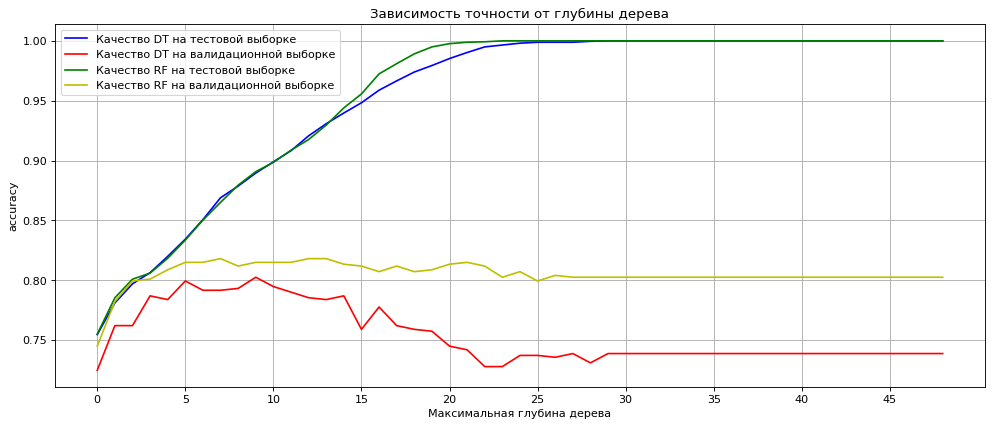

In [20]:
figure(figsize=(15, 6), dpi=80)
plt.plot(DT_train_score, color='b')
plt.plot(DT_valid_score, color='r')
plt.plot(RF_train_score, c='g')
plt.plot(RF_valid_score, c='y')
plt.legend([
    'Качество DT на тестовой выборке', 
    'Качество DT на валидационной выборке',
    'Качество RF на тестовой выборке', 
    'Качество RF на валидационной выборке',
])
plt.xticks(np.arange(0, 50, step=5)) 
plt.ylabel('accuracy')
plt.xlabel('Максимальная глубина дерева')
plt.title('Зависимость точности от глубины дерева')
plt.grid()
plt.show()

У DT точность на валидационной выборке растет до глубины 8-10, дальше точность растет только на тренировочной выборке, на валидационной резко падает - происходит переобучение.

У RF точность достигает максимума в интервале глубины 8-20, дальше точность на валидационной несколько снижается - по всей видимости несмотря на стойкость RF к переобучению, качество модели тоже снижается.

После того как качество DT и RF на тестовой выборке достигает единицы, дальнейшее разбиение решающих деревьев на узлы прекращается и модель перестает менятся - как, соответственно и результат на валидационных данных)

Точность RF выше чем DT - что логично)

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех:

Огонь! Буду твою работу показывать другим студентам, чтобы знали как надо)
    
    
У RF тоже припадает, но разница есть, он скорее застывает, а DT падает и падает. Отличная иллюстрация того как RF устойчив к переобучению, а DT сильно переобучается.  Вот такую идею я и мел в виду.      
</div>

## Проверьте модель на тестовой выборке

Проверим лучшую модель на валидационных данных

In [21]:
score = best_model.score(features_valid, target_valid)
score

0.8164852255054432

Наилучший результат получаем при использовании случайного леса как на тренировочных данных так и на тестовых.

## (бонус) Проверьте модели на адекватность

Построим простой классификатор, который выдаёт на каждом объекте константное предсказание – самый часто встречающийся класс.

In [22]:
simple_model = DummyClassifier(strategy="most_frequent") 
simple_model.fit(features_train, target_train) 

DummyClassifier(strategy='most_frequent')

In [23]:
score = simple_model.score(features_valid, target_valid)
score

0.6936236391912908

### Вывод: 
На рассматриваемом датасете dummy-классификатор предсказывает результат хуже чем случайный лес или решающе дерево, но почти так же хорошо как логистическая регрессия

# Вывод

В работе решалась задача построения класификатора, позволяющего рекомендовать тариф польщователю в соответствии с его поведением. 

В ходе работы было проведено исследование и выбран наилучший классификатор из списка:`RandomForestClassifier`, `LogisticRegression`, `DecisionTreeClassifier`  для поставленной задачи.

Данные были разбиты на обучающую и тестовую выборки, подбор оптимальных параметров моделей происходил при помощи рандомного поиска с использованием кросс-валидации.

В качества наилучшей модели по результатам на обучающей выборке данных была выбран `RandomForestClassifier`.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
